In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
import datetime
import os
dp = '/home/ebert/jupyter-notebooks/FNode-data'

In [22]:
exp_name = '2018_01_23_12_37_56_cs-rb-loading'
if exp_name:
    exp_date = '_'.join(exp_name.split('_')[:3])
    experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
else:
    experiment_file = ''
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
print "ivars: {}".format(q.experiments[0]['variable_list'])
results = q.generate_thresholds()
cs_cuts = [[23],[4]]
rb_cuts = [[20],[3]]
q.set_thresholds(cs_cuts, roi=0)
q.set_thresholds(rb_cuts, roi=1)
retention = q.apply_thresholds()
cuts = q.get_thresholds()
roi_map = ['cs', 'rb']
#tbl_str = "ivar:\t{0}\tretention:{1:.3f} +- {2:.3f}"
tbl_str = "ivar:\t{0}\tretention:{1} +- {2}"
entries = np.product(retention['retention'].shape[:-1])
for i in range(entries):
    print(tbl_str.format(
        retention['ivar'].reshape((entries,-1))[i][0],
        retention['retention'].reshape((entries,-1))[i],
        retention['error'].reshape((entries,-1))[i]
    ))
q.save_experiment_data()

ivars: []


/home/ebert/jupyter-notebooks/FNode/analyses/qdp/QDP/qdp.py:32: RuntimeWarning: invalid value encountered in log
  return (m1*s0**2-m0*s1**2-np.sqrt(s0**2*s1**2*(m0**2-2*m0*m1+m1**2+2*np.log((1-A1)/A1)*(s1**2-s0**2))))/(s0**2-s1**2)
/home/ebert/jupyter-notebooks/FNode/analyses/qdp/QDP/qdp.py:32: RuntimeWarning: invalid value encountered in sqrt
  return (m1*s0**2-m0*s1**2-np.sqrt(s0**2*s1**2*(m0**2-2*m0*m1+m1**2+2*np.log((1-A1)/A1)*(s1**2-s0**2))))/(s0**2-s1**2)


ivar:	0.0	retention:[ 0.06933333  0.99740052] +- [ 0.00298539  0.00060554]


<IPython.core.display.Javascript object>


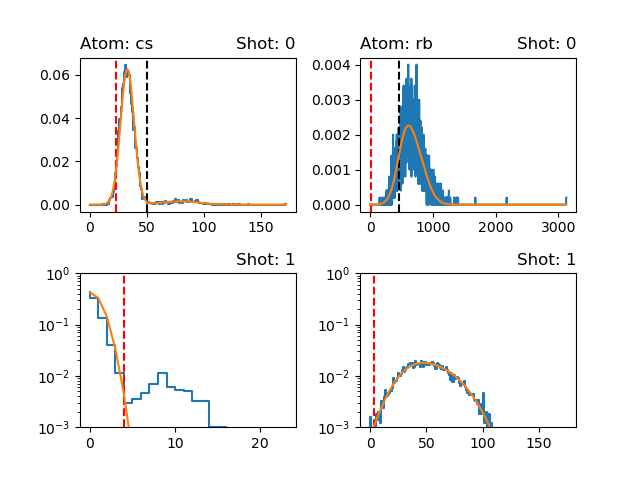

[50.444317988325921]
[466.01529511960649]
[nan]
[nan]


In [23]:
shift = 0
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for s in range(2):
    for r in range(2):
        ax[s][r].step(results[r][s]['hist_x']+shift, results[r][s]['hist_y'])
        xs = np.arange(max(results[r][s]['hist_x'])+1)

        for i, xc in enumerate(results[r][s]['cuts']):
            ax[s][r].axvline(x=xc, color='k', linestyle='--')
            ax[s][r].axvline(x=cuts[r][s][i], color='r', linestyle='--')
        if results[r][s]['fit_params'].shape[0]:
            ax[s][r].plot(xs, qdp.dblgauss(xs, *results[r][s]['fit_params']))
        print(results[r][s]['cuts'])
        if s>0:
            ax[s][r].set_yscale('log', nonposy='clip')
            ax[s][r].set_ylim(1e-3, 1e0)
        else:
            ax[s][r].set_title('Atom: {}'.format(roi_map[r]), loc='left')
        ax[s][r].set_title('Shot: {}'.format(s), loc='right')
# print results[s]['fit_params']
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/2
# print(results[s]['fit_params'][3]-results[s]['fit_params'][2])/results[s]['fit_params'][2]

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'readout_hist_grid.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

<IPython.core.display.Javascript object>


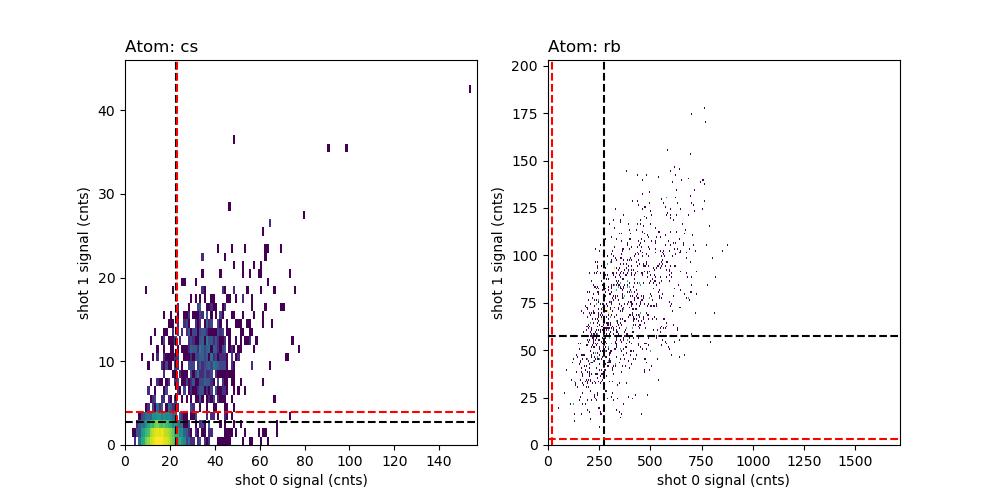

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
for r in range(2):
    s0_data = q.experiments[0]['iterations'][0]['signal_data'][:,0,r,0]
    s1_data = q.experiments[0]['iterations'][0]['signal_data'][:,1,r,0]
    ax[r].hist2d(s0_data, s1_data, norm=LogNorm(), bins=[np.arange(max(s0_data)+5),np.arange(max(s1_data)+5)])

    for xc in results[r][0]['cuts']:
        ax[r].axvline(x=xc, color='k', linestyle='--')
        ax[r].axvline(x=cuts[r][0][0], color='r', linestyle='--')
    for xc in results[r][1]['cuts']:
        ax[r].axhline(y=xc, color='k', linestyle='--')
        ax[r].axhline(y=cuts[r][1][0], color='r', linestyle='--')

    ax[r].set_xlabel('shot 0 signal (cnts)')
    ax[r].set_ylabel('shot 1 signal (cnts)')
    ax[r].set_title('Atom: {}'.format(roi_map[r]), loc='left')

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'readout_2d_scatter.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=300, format=fmt)

<IPython.core.display.Javascript object>


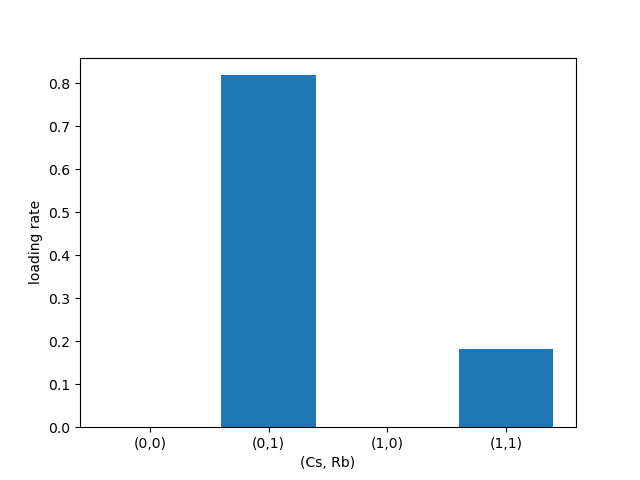

[[ 0.          0.81903619]
 [ 0.          0.18096381]]


In [21]:
fig, ax = plt.subplots()
qd = q.experiments[0]['iterations'][0]['quantized_data'][:,0]
load_mat = np.zeros((2,2))
for c in range(2):
    for r in range(2):
        load_mat[c,r] = np.sum(np.all(qd==np.array([c,r]), axis=1), dtype='float')/qd.shape[0]
print load_mat
ax.bar(range(4), load_mat.flatten())
ax.set_xticks(range(4))
ax.set_xticklabels(['({},{})'.format(i//2, i%2) for i in range(4)])
ax.set_xlabel('(Cs, Rb)')
ax.set_ylabel('loading rate')

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'readout_dual_loading.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [11]:
s1 = np.mean(q.experiments[0]['iterations'][0]['signal_data'][q.experiments[0]['iterations'][0]['quantized_data'][:,0].astype('bool'),0])
s0 = np.mean(q.experiments[0]['iterations'][0]['signal_data'][np.logical_not(q.experiments[0]['iterations'][0]['quantized_data'][:,0]).astype('bool'),0])
print(s0, s1)
print s1 + 2*np.sqrt(s1)

(2.8574821852731591, 24.224899598393574)
34.0686589612


In [128]:
nonss_iter = 0
s1_cut = q.experiments[0]['iterations'][nonss_iter]['signal_data'][q.experiments[0]['iterations'][nonss_iter]['quantized_data'][:,0].astype('bool'),1]
s1_nocut = q.experiments[0]['iterations'][nonss_iter]['signal_data'][np.logical_not(q.experiments[0]['iterations'][nonss_iter]['quantized_data'][:,0].astype('bool')),1]

ss_iter = 1
s1_cut_ss = q.experiments[0]['iterations'][ss_iter]['signal_data'][q.experiments[0]['iterations'][ss_iter]['quantized_data'][:,0].astype('bool'),1]
s1_nocut_ss = q.experiments[0]['iterations'][ss_iter]['signal_data'][np.logical_not(q.experiments[0]['iterations'][ss_iter]['quantized_data'][:,0].astype('bool')),1]

KeyError: 1

<IPython.core.display.Javascript object>


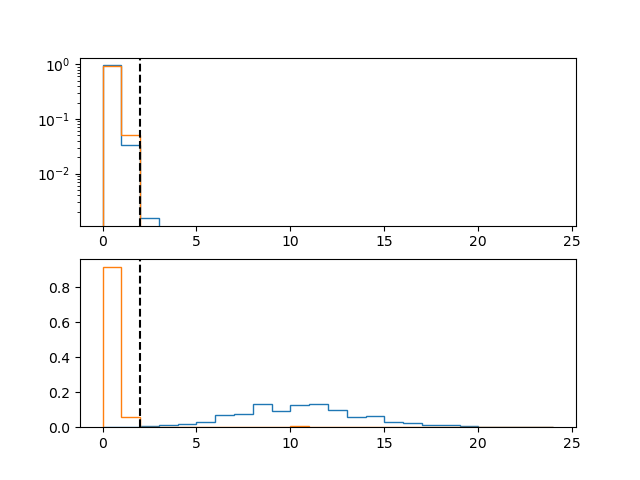

In [260]:
fig, ax = plt.subplots(2)

ax[0].hist(s1_nocut, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[0].hist(s1_nocut_ss, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[0].axvline(x=cuts[1][0], color='k', linestyle='--')
ax[0].set_yscale('log', nonposy='clip')
ax[1].hist(s1_cut, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')
ax[1].hist(s1_cut_ss, bins=np.arange(max(s1_cut)+1), density=True, histtype='step')

#ax[1].set_yscale('log', nonposy='clip')
ax[1].axvline(x=cuts[1][0], color='k', linestyle='--')

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 's1_readout_ss-nonss_comp.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

s1_sig = np.mean(s1_cut)
s1_bg = np.mean(s1_nocut)

In [241]:
s1_sig/np.array([1,0.5])

array([ 10.048,  20.096])

In [242]:
s1_bg/np.array([1,0.5])

array([ 0.0368947 ,  0.07378939])

In [264]:
float(np.sum(s1_nocut > 1))/s1_nocut.shape[0]

0.0015372790161414297

In [262]:
np.sum(s1_nocut_ss > 1)

0